In [1]:
import tensorflow as tf
from datasets import MNISTDataset
from time import time
import os

#Setting Up Log File for Tensorboard

In [2]:

(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.mnist.load_data()
mnist = MNISTDataset(train_imgs.reshape((-1, 784)), train_lbls,
                     test_imgs.reshape((-1, 784)), test_lbls,
                     batch_size=256,
                     seed=int(time())
                     )

# first change: set up log dir and file writer(s)
import time
logdir1 = os.path.join("logs1", "linear" + str(time.time()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir1, "train"))
test_writer = tf.summary.create_file_writer(os.path.join(logdir1, "test"))
gradient_writer = tf.summary.create_file_writer(os.path.join(logdir1, "gradient"))

##Model 1

Here are a few suggestions and their results


---


with regularizations

lr=0.0025

batch=128

Loss: 0.556975245475769 Accuracy: 0.796875

Final test accuracy: 0.8029999732971191


---



lr = 0.0025

no regularizations

batch sizea=128

Train accuracy: 0.875

Test accuracy: 0.8687999844551086


---



lr = 0.001

batch=128

Loss: 0.7130742073059082 Accuracy: 0.7578125

Final test accuracy: 0.7803999781608582



---



In [3]:
# define the model first, from input to output

# this is a super deep model, cool!
n_units = 100
n_layers = 8
w_range = 0.4

# just set up a "chain" of hidden layers
layers = []
for layer in range(n_layers):
    layers.append(tf.keras.layers.Dense(
        n_units, activation=tf.nn.relu,
        kernel_initializer=tf.initializers.RandomUniform(minval=-w_range,
                                                         maxval=w_range),
        bias_initializer=tf.initializers.constant(0.001)))
    
print(tf.initializers.RandomUniform(minval=-w_range,
                                                         maxval=w_range))

# finally add the output layer
layers.append(tf.keras.layers.Dense(
    10, kernel_initializer=tf.initializers.RandomUniform(minval=-w_range,
                                                         maxval=w_range)))

lr = 0.1
for step in range(2000):
    img_batch, lbl_batch = mnist.next_batch()
    with tf.GradientTape() as tape:
        # here we just run all the layers in sequence via a for-loop
        out = img_batch
        for layer in layers:
            out = layer(out)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=out, labels=lbl_batch))

    weights = [var for l in layers for var in l.trainable_variables]
    grads = tape.gradient(xent, weights)
    
    
    for grad, var in zip(grads, weights):
        var.assign_sub(lr*grad)
        gradients = tf.norm(grad, ord='euclidean', axis=None, keepdims=None, name=None)

    # change #2: log this stuff every time step (rather wasteful)
    with train_writer.as_default():
          tf.summary.scalar("loss", xent, step=step)
          tf.summary.histogram("logits", out, step=step)
          tf.summary.histogram("weights", var, step=step)

    with gradient_writer.as_default():
      tf.summary.scalar("gradients", gradients, step=step)

    if not step % 100:
        preds = tf.argmax(out, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))



        # change #3: log this only once every 100 steps
        with test_writer.as_default():
            tf.summary.scalar("accuracy", acc, step=step)
            tf.summary.image("input", tf.reshape(img_batch, [-1, 28, 28, 1]), step=step)




        


    out = mnist.test_data
    for layer in layers:
      out = layer(out)
    test_preds = tf.argmax(out, axis=1, output_type=tf.int32)
    test_acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, mnist.test_labels), tf.float32))
    with test_writer.as_default():
      tf.summary.scalar("accuracy", test_acc, step=step)
print("Final test accuracy: {}".format(test_acc))


Loss: 178.66278076171875 Accuracy: 0.125
Loss: nan Accuracy: 0.109375
Loss: nan Accuracy: 0.1015625
Starting new epoch...
Loss: nan Accuracy: 0.0703125
Loss: nan Accuracy: 0.109375
Starting new epoch...
Loss: nan Accuracy: 0.13671875
Loss: nan Accuracy: 0.08203125
Loss: nan Accuracy: 0.078125
Starting new epoch...
Loss: nan Accuracy: 0.0859375
Loss: nan Accuracy: 0.0625
Starting new epoch...
Loss: nan Accuracy: 0.09375
Loss: nan Accuracy: 0.12109375
Starting new epoch...
Loss: nan Accuracy: 0.11328125
Loss: nan Accuracy: 0.0703125
Loss: nan Accuracy: 0.1015625
Starting new epoch...
Loss: nan Accuracy: 0.078125
Loss: nan Accuracy: 0.08984375
Starting new epoch...
Loss: nan Accuracy: 0.078125
Loss: nan Accuracy: 0.1171875
Starting new epoch...
Loss: nan Accuracy: 0.08203125
Final test accuracy: 0.09799999743700027


#Inference from model 1
The gradient plot reveals an exploding gradient problem which is caused by large variance during weight initialization which can also be dependent on the network architecture, this theory is suported by this  [paper](https://arxiv.org/pdf/1712.08969.pdf). A quick fix is to reduce the learning rate, change the activation function to a non linear activation function, (as relu is linear funtion and allows exploding gradients) or alter the network architecture(reduce number of units to 50).  

In [11]:
# then load/run tensorboard
#%TMP% delete TFinfo 
#%load_ext tensorboard


%reload_ext tensorboard

In [15]:
%tensorboard --logdir logs1

Reusing TensorBoard on port 6006 (pid 11308), started 0:01:36 ago. (Use '!kill 11308' to kill it.)

##Model 2
Here are a few suggestions and their results

---



lr=0.1

activation function = relu

step=2000

Loss: 0.2918747663497925 Accuracy: 0.9296875

Final test accuracy: 0.9363999962806702

---


lr=0.1

activation function = relu

step=4000

Loss: 0.0701780766248703 Accuracy: 0.984375

Final test accuracy: 0.9546999931335449

---




In [12]:
from time import time

# first change: set up log dir and file writer(s)
import time
logdir2 = os.path.join("logs2", "linear" + str(time.time()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir2, "train"))
test_writer = tf.summary.create_file_writer(os.path.join(logdir2, "test"))
gradient_writer = tf.summary.create_file_writer(os.path.join(logdir2, "gradient"))



# define the model first, from input to output

# this is a super deep model, cool!
n_units = 100
n_layers = 8
w_range = 0.1

# just set up a "chain" of hidden layers
layers = []
for layer in range(n_layers):
    layers.append(tf.keras.layers.Dense(
        n_units, activation=tf.nn.sigmoid,
        kernel_initializer=tf.initializers.RandomUniform(minval=-w_range,
                                                         maxval=w_range),
        bias_initializer=tf.initializers.constant(0.001)))

# finally add the output layer
layers.append(tf.keras.layers.Dense(
    10, kernel_initializer=tf.initializers.RandomUniform(minval=-w_range,
                                                         maxval=w_range)))

lr = 0.1
for step in range(2000):
    img_batch, lbl_batch = mnist.next_batch()
    with tf.GradientTape() as tape:
        # here we just run all the layers in sequence via a for-loop
        out = img_batch
        for layer in layers:
            out = layer(out)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=out, labels=lbl_batch))

    weights = [var for l in layers for var in l.trainable_variables]
    grads = tape.gradient(xent, weights)
   
    for grad, var in zip(grads, weights):
        var.assign_sub(lr*grad)
        gradients = tf.norm(grad, ord='euclidean', axis=None, keepdims=None, name=None)

    
    # change #2: log this stuff every time step (rather wasteful)
    with train_writer.as_default():
      tf.summary.scalar("loss", xent, step=step)
      tf.summary.histogram("logits", out, step=step)
      tf.summary.histogram("weights", var, step=step)



    with gradient_writer.as_default():
        tf.summary.scalar("gradients", gradients, step=step)



    if not step % 100:
        preds = tf.argmax(out, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))


    # change #3: log this only once every 100 steps
    with train_writer.as_default():
        tf.summary.scalar("accuracy", acc, step=step)
        tf.summary.image("input", tf.reshape(img_batch, [-1, 28, 28, 1]), step=step)


    out = mnist.test_data
    for layer in layers:
      out = layer(out)
    test_preds = tf.argmax(out, axis=1, output_type=tf.int32)
    test_acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, mnist.test_labels), tf.float32))
    with test_writer.as_default():
      tf.summary.scalar("accuracy", test_acc, step=step)
print("Final test accuracy: {}".format(test_acc))

Loss: 2.3376903533935547 Accuracy: 0.10546875
Loss: 2.3049392700195312 Accuracy: 0.1015625
Starting new epoch...
Loss: 2.3081536293029785 Accuracy: 0.09765625
Loss: 2.3009493350982666 Accuracy: 0.140625
Starting new epoch...
Loss: 2.3106703758239746 Accuracy: 0.125
Loss: 2.299367904663086 Accuracy: 0.1328125
Starting new epoch...
Loss: 2.31538462638855 Accuracy: 0.08984375
Loss: 2.311196804046631 Accuracy: 0.1015625
Loss: 2.3054192066192627 Accuracy: 0.10546875
Starting new epoch...
Loss: 2.309871196746826 Accuracy: 0.09765625
Loss: 2.304586410522461 Accuracy: 0.109375
Starting new epoch...
Loss: 2.3012678623199463 Accuracy: 0.09375
Loss: 2.3007140159606934 Accuracy: 0.1015625
Starting new epoch...
Loss: 2.3023059368133545 Accuracy: 0.1328125
Loss: 2.3037219047546387 Accuracy: 0.1015625
Loss: 2.2981789112091064 Accuracy: 0.09375
Starting new epoch...
Loss: 2.306993007659912 Accuracy: 0.078125
Loss: 2.295621395111084 Accuracy: 0.12109375
Starting new epoch...
Loss: 2.304694652557373 Acc

#Inference from model 2
Here, the gradient plot reveals a vanishing gradient problem, caused by the sigmoid function streamling all input to [0, 1], that can be resolved by using a linear activation function like relu [max, 0]. 


In [13]:
# then load/run tensorboard

# %load_ext tensorboard

%reload_ext tensorboard

In [14]:
%tensorboard --logdir logs2

Launching TensorBoard...

KeyboardInterrupt: 

##Model 3

kernerInitializer - maxval = 0.01

Loss: 0.3130064606666565 Accuracy: 0.93359375

Final test accuracy: 0.9319000244140625

---

kernerInitializer - maxval = 0.01

steps = 4000

Loss: 0.10393001139163971 Accuracy: 0.97265625

Final test accuracy: 0.9617000222206116

---

In [29]:
# first change: set up log dir and file writer(s)
import time
import os
logdir3 = os.path.join("logs3", "linear3" + str(time.time()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir3, "train"))
test_writer = tf.summary.create_file_writer(os.path.join(logdir3, "test"))
gradient_writer = tf.summary.create_file_writer(os.path.join(logdir3, "gradient"))


# let's use fewer layers...
n_units = 100
n_layers = 2

# just set up a "chain" of hidden layers
layers = []
for layer in range(n_layers):
    layers.append(tf.keras.layers.Dense(
        n_units, activation=tf.nn.relu,
        kernel_initializer=tf.initializers.RandomUniform(minval=-0.01,
                                                         maxval=0.),
        bias_initializer=tf.initializers.constant(0.001)))

# finally add the output layer
layers.append(tf.keras.layers.Dense(
    10, kernel_initializer=tf.initializers.RandomUniform(minval=-0.01,
                                                         maxval=0.01)))


lr = 0.1
for step in range(2000):
    img_batch, lbl_batch = mnist.next_batch()
    with tf.GradientTape() as tape:
        # here we just run all the layers in sequence via a for-loop
        out = img_batch
        for layer in layers:
            out = layer(out)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=out, labels=lbl_batch))

    weights = [var for l in layers for var in l.trainable_variables]
    grads = tape.gradient(xent, weights)
    for grad, var in zip(grads, weights):
        var.assign_sub(lr*grad)
    gradients = tf.norm(grad, ord='euclidean', axis=None, keepdims=None, name=None)

    
    with gradient_writer.as_default():
      tf.summary.scalar("gradients", gradients, step=step)
  
    if not step % 100:
        preds = tf.argmax(out, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))


    # change #3: log this only once every 100 steps
    with train_writer.as_default():
        tf.summary.scalar("accuracy", acc, step=step)
        tf.summary.image("input", tf.reshape(img_batch, [-1, 28, 28, 1]), step=step)


    # change #2: log this stuff every time step (rather wasteful)
    with train_writer.as_default():
        tf.summary.scalar("loss", xent, step=step)
        tf.summary.histogram("logits", out, step=step)
        tf.summary.histogram("weights", var, step=step)




    out = mnist.test_data
    for layer in layers:
      out = layer(out)
    test_preds = tf.argmax(out, axis=1, output_type=tf.int32)
    test_acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, mnist.test_labels), tf.float32))
    with test_writer.as_default():
      tf.summary.scalar("accuracy", test_acc, step=step)
print("Final test accuracy: {}".format(test_acc))


Loss: 2.3025851249694824 Accuracy: 0.109375
Loss: 2.299927234649658 Accuracy: 0.1171875
Loss: 2.3056793212890625 Accuracy: 0.06640625
Starting new epoch...
Loss: 2.303879737854004 Accuracy: 0.1328125
Loss: 2.3015518188476562 Accuracy: 0.125
Starting new epoch...
Loss: 2.301048994064331 Accuracy: 0.1015625
Loss: 2.299473524093628 Accuracy: 0.10546875
Starting new epoch...
Loss: 2.2982640266418457 Accuracy: 0.1171875
Loss: 2.306756019592285 Accuracy: 0.09765625
Loss: 2.3043737411499023 Accuracy: 0.09375
Starting new epoch...
Loss: 2.2929465770721436 Accuracy: 0.15625
Loss: 2.305248498916626 Accuracy: 0.09375
Starting new epoch...
Loss: 2.3037900924682617 Accuracy: 0.09765625
Loss: 2.30401349067688 Accuracy: 0.09375
Loss: 2.303297758102417 Accuracy: 0.1171875
Starting new epoch...
Loss: 2.297632932662964 Accuracy: 0.12109375
Loss: 2.3020265102386475 Accuracy: 0.1171875
Starting new epoch...
Loss: 2.3050284385681152 Accuracy: 0.09765625
Loss: 2.3008852005004883 Accuracy: 0.12109375
Startin

#Inference from model 3
We experience a vanishing gradient promblem here, caused by a non zero mean in weights initialization and non uniform variance in all the respective layers. change `maxval` to 0.01

In [0]:
%tensorboard --logdir logs3

##Model 4

A standard deviation of 4 is too high and adds too much noise into the data to an extent that the model cannot identify the features of the image
The average standard deviation observed during research is between 0 and 1


---


Std Dev = 1

Loss: 0.7794443368911743 Accuracy: 0.75

Final test accuracy: 0.9099000096321106



---


Std Dev = 0.5

Loss: 0.4842979907989502 Accuracy: 0.84375

Final test accuracy: 0.9297999739646912



---


Std Dev = 0.25

Loss: 0.33627036213874817 Accuracy: 0.87890625

Final test accuracy: 0.9330000281333923



---



In [31]:
import tensorflow as tf


# first change: set up log dir and file writer(s)
import time
logdir4 = os.path.join("logs4", "linear4" + str(time.time()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir4, "train"))
test_writer = tf.summary.create_file_writer(os.path.join(logdir4, "test"))
gradient_writer = tf.summary.create_file_writer(os.path.join(logdir4, "gradient"))


# let's use fewer layers...
n_units = 100
n_layers = 2

# just set up a "chain" of hidden layers
layers = []
for layer in range(n_layers):
    layers.append(tf.keras.layers.Dense(
        n_units, activation=tf.nn.relu,
        kernel_initializer=tf.initializers.RandomUniform(minval=-0.01,
                                                         maxval=0.01),
        bias_initializer=tf.initializers.constant(0.001)))

# finally add the output layer
layers.append(tf.keras.layers.Dense(
    10, kernel_initializer=tf.initializers.RandomUniform(minval=-0.01,
                                                         maxval=0.01)))



lr = 0.1
for step in range(2000):
    img_batch, lbl_batch = mnist.next_batch()
    # I hear adding random noise to inputs helps with generalization!
    img_batch = img_batch + tf.random.normal(tf.shape(img_batch), stddev=0.4)
    with tf.GradientTape() as tape:

        # here we just run all the layers in sequence via a for-loop
        out = img_batch
        for layer in layers:
            out = layer(out)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=out, labels=lbl_batch))

    weights = [var for l in layers for var in l.trainable_variables]
    grads = tape.gradient(xent, weights)
    for grad, var in zip(grads, weights):
        var.assign_sub(lr*grad)
    gradients = tf.norm(grad, ord='euclidean', axis=None, keepdims=None, name=None)

    
    with gradient_writer.as_default():
      tf.summary.scalar("gradients", gradients, step=step)
  
    if not step % 100:
        preds = tf.argmax(out, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))


    # change #3: log this only once every 100 steps
    with train_writer.as_default():
        tf.summary.scalar("accuracy", acc, step=step)
        tf.summary.image("input", tf.reshape(img_batch, [-1, 28, 28, 1]), step=step)


    # change #2: log this stuff every time step (rather wasteful)
    with train_writer.as_default():
        tf.summary.scalar("loss", xent, step=step)
        tf.summary.histogram("logits", out, step=step)
        tf.summary.histogram("weights", var, step=step)

    out = mnist.test_data
    for layer in layers:
      out = layer(out)
    test_preds = tf.argmax(out, axis=1, output_type=tf.int32)
    test_acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, mnist.test_labels), tf.float32))
    with test_writer.as_default():
      tf.summary.scalar("accuracy", test_acc, step=step)
print("Final test accuracy: {}".format(test_acc))

Loss: 2.302567958831787 Accuracy: 0.09765625
Loss: 2.3015096187591553 Accuracy: 0.0859375
Starting new epoch...
Loss: 2.2999794483184814 Accuracy: 0.125
Loss: 2.301260471343994 Accuracy: 0.09375
Starting new epoch...
Loss: 2.289503574371338 Accuracy: 0.14453125
Loss: 2.299851894378662 Accuracy: 0.0859375
Starting new epoch...
Loss: 2.093125343322754 Accuracy: 0.25
Loss: 1.2149486541748047 Accuracy: 0.546875
Loss: 0.8785444498062134 Accuracy: 0.6875
Starting new epoch...
Loss: 0.7454255223274231 Accuracy: 0.7578125
Loss: 0.6598219275474548 Accuracy: 0.77734375
Starting new epoch...
Loss: 0.6503037214279175 Accuracy: 0.80859375
Loss: 0.6118203401565552 Accuracy: 0.76953125
Starting new epoch...
Loss: 0.6084169745445251 Accuracy: 0.828125
Loss: 0.5856684446334839 Accuracy: 0.80859375
Loss: 0.5546771287918091 Accuracy: 0.8515625
Starting new epoch...
Loss: 0.46970653533935547 Accuracy: 0.8203125
Loss: 0.37128424644470215 Accuracy: 0.89453125
Starting new epoch...
Loss: 0.4478006362915039 A

#Inference on Model 4

The weights are properly centered as opposed to model 3. The addition of noise makes it difficult for the network to memorize the data, such that with a final training accuracy of 0.28, we have the test accuracy of 0.74. To increase test accuracy feed the network a noise of 0.1 standard deviation.

In [0]:
%tensorboard --logdir logs4

##Model 5

Remove the unnecessary activation 
funtion tf.nn.softmax


In [0]:
from time import time


# first change: set up log dir and file writer(s)
import time
logdir5 = os.path.join("logs5", "linear5" + str(time.time()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir5, "train"))
test_writer = tf.summary.create_file_writer(os.path.join(logdir5, "test"))
gradient_writer = tf.summary.create_file_writer(os.path.join(logdir5, "gradient"))




# let's use fewer layers...
n_units = 100
n_layers = 2

# just set up a "chain" of hidden layers
layers = []
for layer in range(n_layers):
    layers.append(tf.keras.layers.Dense(
        n_units, activation=tf.nn.relu,
        kernel_initializer=tf.initializers.RandomUniform(minval=-0.01,
                                                         maxval=0.01),
        bias_initializer=tf.initializers.constant(0.001)))

# finally add the softmax output layer :))
layers.append(tf.keras.layers.Dense(
    10, activation=tf.nn.elu,
    kernel_initializer=tf.initializers.RandomUniform(minval=-0.01,
                                                     maxval=0.01)))

lr = 0.1
for step in range(2000):
    img_batch, lbl_batch = mnist.next_batch()
    with tf.GradientTape() as tape:
        # here we just run all the layers in sequence via a for-loop
        out = img_batch
        for layer in layers:
            out = layer(out)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=out, labels=lbl_batch))

    weights = [var for l in layers for var in l.trainable_variables]
    grads = tape.gradient(xent, weights)
    for grad, var in zip(grads, weights):
        var.assign_sub(lr*grad)
    gradients = tf.norm(grad, ord='euclidean', axis=None, keepdims=None, name=None)

    
    with gradient_writer.as_default():
      tf.summary.scalar("gradients", gradients, step=step)
      
  
    if not step % 100:
        preds = tf.argmax(out, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))


    # change #3: log this only once every 100 steps
    with train_writer.as_default():
        tf.summary.scalar("accuracy", acc, step=step)
        tf.summary.image("input", tf.reshape(img_batch, [-1, 28, 28, 1]), step=step)


    # change #2: log this stuff every time step (rather wasteful)
    with train_writer.as_default():
        tf.summary.scalar("loss", xent, step=step)
        tf.summary.histogram("logits", out, step=step)
        tf.summary.histogram("weights", var, step=step)

    out = mnist.test_data
    for layer in layers:
      out = layer(out)
    test_preds = tf.argmax(out, axis=1, output_type=tf.int32)
    test_acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, mnist.test_labels), tf.float32))
    with test_writer.as_default():
      tf.summary.scalar("accuracy", test_acc, step=step)
print("Final test accuracy: {}".format(test_acc))


Loss: 2.30259370803833 Accuracy: 0.09375
Loss: 2.2945985794067383 Accuracy: 0.1640625
Loss: 2.3022637367248535 Accuracy: 0.09765625
Starting new epoch...
Loss: 2.297896385192871 Accuracy: 0.11328125
Loss: 2.2961297035217285 Accuracy: 0.1171875
Starting new epoch...
Loss: 2.2649710178375244 Accuracy: 0.1953125
Loss: 1.3318147659301758 Accuracy: 0.5
Starting new epoch...
Loss: 0.8630139231681824 Accuracy: 0.67578125
Loss: 0.7104894518852234 Accuracy: 0.79296875
Loss: 0.6176666617393494 Accuracy: 0.81640625
Starting new epoch...
Loss: 0.47712016105651855 Accuracy: 0.83984375
Loss: 0.48497384786605835 Accuracy: 0.87109375
Starting new epoch...
Loss: 0.5943899750709534 Accuracy: 0.83984375
Loss: 0.4000398516654968 Accuracy: 0.890625
Loss: 0.3931143581867218 Accuracy: 0.890625
Starting new epoch...
Loss: 0.3424515426158905 Accuracy: 0.90625
Loss: 0.38362276554107666 Accuracy: 0.8984375
Starting new epoch...
Loss: 0.3049623370170593 Accuracy: 0.9140625
Loss: 0.3414199948310852 Accuracy: 0.910

In [0]:
%load_ext tensorboard

#Inference on Model 5

The use of non linear function `softmax` at the out layer is not recommended. use any of the linear functions for this.

In [0]:
%tensorboard --logdir logs5

#Data Handling with `tf.data`

In [0]:
import numpy as np
import time 

t0 = time.time()


mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


#Normalization and Flattening
train_images = (train_images.astype(np.float32) / 255.).reshape((-1, 784))
test_images = (test_images.astype(np.float32) / 255.).reshape((-1, 784))


#Convsersion of Labels into integers
train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)



# this is now different
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

train_data = train_data.repeat()
train_data = train_data.shuffle(buffer_size=60000)
train_data = train_data.batch(128)

t1= time.time()

print(t1-t0)

0.37395262718200684


#Shuffle, Repeat and Batch Size

To determine `buffer_size`, use the entire length of the dataset, the bigger the better. One disadvantage is that your dataset now takes longer to load. To avoid this disadvantage, do the shuffling and repeating during splitting (contains only file names here) and not when loading.


With the below configuration:

```python
data = tf.data.Dataset.range(4)
data = data.repeat(2) 
data = data.batch(2)  
data = data.shuffle(4)
```
`Shuffle, Repeat, Batch Size` = [2, 1, 3, 0, 3, 0, 2, 1]

`Shuffle,  Batch Size, Repeat` = [2, 3, 0, 1, 2, 1, 3, 0]

`Batch Size, Shuffle, Repeat` = [0, 1, 2, 3, 0, 1, 2, 3]

`Batch Size, Repeat, Shuffle` = [2, 3, 0, 1, 2, 3, 0, 1]

`Repeat, Shuffle, Batch Size` = [1, 3, 1, 0, 2, 3, 2, 0]

`Repeat, Batch Size, Shuffle` = [0, 1, 2, 3, 0, 1, 2, 3]

1. Shuffle, Repeat, Batch Size: Makes you see all the training example in one epoch in no particular order
2. Shuffle,  Batch Size, Repeat = Makes you see all the training example in one epoch  in no particular order
3. Batch Size, Shuffle, Repeat = Makes you see all the training example in one epoch and the next in an orderly form
4. Batch Size, Repeat, Shuffle = Makes you see all the training example in one epoch and the next in an orderly form
5. Repeat, Shuffle, Batch Size = Reduces the chances of seeing all examples of the dataset in one epoch.
6. Repeat, Batch Size, Shuffle = Makes you see all the training example in one epoch and the next in an orderly form

NB: Looking at any pipeline, one can easily determine if a network is feeding based or queue-based.

# Experimenting with TF Data on the model
In this function we perform series of **Repeat,shuffle, batch** operations using tf.data on the dataset

We also make use **Iterator** to iterate over the batch


In [0]:
def processData():
  import tensorflow as tf
  import numpy as np
  import os
  mnist = tf.keras.datasets.mnist
  (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

  #Normalization and Flattening
  train_images = (train_images.astype(np.float32) / 255.).reshape((-1, 784))
  test_images = (test_images.astype(np.float32) / 255.).reshape((-1, 784))

  #Convsersion of Labels into integers
  train_labels = train_labels.astype(np.int32)
  test_labels = test_labels.astype(np.int32)

  train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
  
  # Entire train data is repeated twice, i.e if the size of dataset is 10,000
  # repeat makes 2 copies each element and shuffles it.
  # Shuffle takes the batch of first 1000 elements and batch selects 64 elements
  train_data = train_data.repeat(2).shuffle(buffer_size=1000).batch(64)
  experimentWithTFData(train_data, test_images,test_labels )

  # Get first 1000  images and shuffle them, after shuffling a batch of 64 images is extracted and 
  # all the images of batch are repeated four times. The ouput will consist of 64*4 images
  train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
  train_data = train_data.shuffle(buffer_size=1000).batch(64).repeat(4)
  experimentWithTFData(train_data, test_images,test_labels )

  train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
  train_data = train_data.repeat(2).batch(64).shuffle(buffer_size=1000)
  experimentWithTFData(train_data, test_images,test_labels )


In [0]:
def experimentWithTFData(train_data, test_images,test_labels):
  import os
  import time
  import tensorflow
  tfDataLogDir = os.path.join("tfData", "linear3" + str(time.time()))
  train_writer = tf.summary.create_file_writer(os.path.join(tfDataLogDir, "train"))
  test_writer = tf.summary.create_file_writer(os.path.join(tfDataLogDir, "test"))

  # let's use fewer layers...
  n_units = 100
  n_layers = 2

  # just set up a "chain" of hidden layers
  layers = []
  for layer in range(n_layers):
    layers.append(tf.keras.layers.Dense(
        n_units, activation=tf.nn.relu,
        kernel_initializer=tf.initializers.RandomUniform(minval=-0.01,
                                                        maxval=0.),
        bias_initializer=tf.initializers.constant(0.001)))

    # finally add the output layer
    layers.append(tf.keras.layers.Dense(
        10, kernel_initializer=tf.initializers.RandomUniform(minval=-0.01,
                                                            maxval=0.01)))
  
  lr = 0.001
  for step in range(2000):
    img_batch, lbl_batch = next(iter(train_data))
    with tf.GradientTape() as tape:
    # here we just run all the layers in sequence via a for-loop
      out = img_batch
      for layer in layers:
        out = layer(out)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=out, labels=lbl_batch))

    weights = [var for l in layers for var in l.trainable_variables]
    grads = tape.gradient(xent, weights)
    for grad, var in zip(grads, weights):
      var.assign_sub(lr*grad)      
    i=0        
    with train_writer.as_default():
        tf.summary.scalar("loss", xent, step=step)
        tf.summary.histogram("logits", out, step=step)
        for W in weights:
            tf.summary.histogram("weights"+str(i), W, step=step)
            i+=1
    tf.summary.scalar("Loss", xent, step=step)    
    if not step % 100:
        preds = tf.argmax(out, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))
        with train_writer.as_default():
            tf.summary.scalar("Trainaccuracy", acc, step=step)
            tf.summary.image("input", tf.reshape(img_batch, [-1, 28, 28, 1]), step=step)

  out = test_images
  for layer in layers:
    out = layer(out)
    test_preds = tf.argmax(out, axis=1, output_type=tf.int32)
    test_acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, test_labels), tf.float32))
  with test_writer.as_default():
    tf.summary.scalar("accuracy", test_acc, step=step)
  print("Final test accuracy: {}".format(test_acc))


In [0]:
processData()

# Visualization
We try to visualize one of the weight vectors and how it gets updated over time and create an animation gif

In [38]:
import tensorflow as tf
import os
import math
from datasets import MNISTDataset
import time

os.getcwd()
logdir = os.path.join("logs", "linear" + str(time.time()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir, "train"))
test_writer = tf.summary.create_file_writer(os.path.join(logdir, "test"))

(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.mnist.load_data()
mnist = MNISTDataset(train_imgs.reshape((-1, 784)), train_lbls,
                     test_imgs.reshape((-1, 784)), test_lbls,
                     batch_size=128, seed=int(time.time()))
n_units = 100
n_layers = 8
w_range = 0.4

layers = []
for layer in range(n_layers):
  layers.append(tf.keras.layers.Dense(
        n_units, activation=tf.nn.relu,
        kernel_initializer=tf.initializers.RandomUniform(minval=-w_range,
                                                         maxval=w_range),
        bias_initializer=tf.initializers.constant(0.001),
        activity_regularizer=tf.keras.regularizers.l2(0.1)))

layers.append(tf.keras.layers.Dense(
    10, kernel_initializer=tf.initializers.RandomUniform(minval=-w_range,
                                                         maxval=w_range),
        bias_initializer=tf.initializers.constant(0.001),
        activity_regularizer=tf.keras.regularizers.l2(0.1)))

weightHistory = []
lr = 0.0025
for step in range(2000):
    img_batch, lbl_batch = mnist.next_batch()

    with tf.GradientTape() as tape:
        out = img_batch
        for layer in layers:
            out = layer(out)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=out, labels=lbl_batch))
    weights = [var for l in layers for var in l.trainable_variables]
    grads = tape.gradient(xent, weights)
    for grad, var in zip(grads, weights):
        var.assign_sub(lr*grad)
    i=0        
    if not step % 100:
        preds = tf.argmax(out, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))

    History = [layers[0].trainable_variables[0]]
    weightHistory.append(History)
out = mnist.test_data
for layer in layers:
    out = layer(out)
test_preds = tf.argmax(out, axis=1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, mnist.test_labels), tf.float32))
print("Final test accuracy: {}".format(acc))


Loss: 141.35494995117188 Accuracy: 0.1015625
Loss: 2.8934600353240967 Accuracy: 0.3203125
Loss: 1.7831906080245972 Accuracy: 0.5390625
Loss: 1.616523265838623 Accuracy: 0.453125
Loss: 1.0778954029083252 Accuracy: 0.6484375
Starting new epoch...
Loss: 0.849216103553772 Accuracy: 0.7265625
Loss: 1.0690202713012695 Accuracy: 0.6796875
Loss: 1.0295464992523193 Accuracy: 0.7109375
Loss: 1.154308795928955 Accuracy: 0.6015625
Loss: 0.8497653007507324 Accuracy: 0.734375
Starting new epoch...
Loss: 0.8377212285995483 Accuracy: 0.7421875
Loss: 0.9917375445365906 Accuracy: 0.6875
Loss: 0.7171486616134644 Accuracy: 0.7578125
Loss: 0.737640380859375 Accuracy: 0.734375
Loss: 0.7550614476203918 Accuracy: 0.7265625
Starting new epoch...
Loss: 0.43732765316963196 Accuracy: 0.8125
Loss: 0.8233800530433655 Accuracy: 0.71875
Loss: 0.7033606171607971 Accuracy: 0.765625
Loss: 0.6245964169502258 Accuracy: 0.796875
Starting new epoch...
Loss: 0.7371636629104614 Accuracy: 0.7578125
Final test accuracy: 0.79900

Create a matrix of zeros and initialize the board with the weight. And then call the animate method to iterate over the weight updations and create an animation of the weight vector

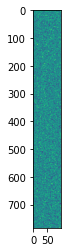

Adding frame 0
Adding frame 0
Adding frame 100
Adding frame 200
Adding frame 300
Adding frame 400
Adding frame 500
Adding frame 600
Adding frame 700
Adding frame 800
Adding frame 900


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

len(weightHistory)

x = 784               # board will be X by Y where X = boardsize
y = 100
pad = 0               # padded border, do not change this!
initial_cells = 1500  # this number of initial cells will be placed in randomly generated positions
my_board = np.zeros((x+pad,y+pad))
my_board = weightHistory[25][0].numpy()
fig = plt.gcf()
im = plt.imshow(my_board)
plt.show()

i = 0
def animate(frame):
    if not frame % 100:
      print("Adding frame",frame)
    my_board = np.array(weightHistory[frame][0].numpy())
    im.set_data(my_board)
    return im

anim = animation.FuncAnimation(fig, animate, frames=1000,interval=10)
anim.save('animation.mp4')